In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.initializers import RandomNormal, Constant

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, QuantileTransformer, RobustScaler, StandardScaler,MinMaxScaler
from tensorflow.keras.optimizers  import Adam, Adagrad, SGD, RMSprop

from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split 

import fairness_helpers as fh
import utilities
import global_variables as gv

#### load data

In [2]:
df = pd.read_csv('data/binary_full.csv')
pd.set_option('display.max_columns', None)
df.drop('Unnamed: 0', axis=1, inplace=True)

#### retreive model

In [5]:
model = keras.models.load_model('saved_models/mlp_binary_1.h5')
model.compile(loss='binary_crossentropy', #categorical_hinge
              optimizer=SGD(learning_rate=0.0005),
              metrics=['acc',tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

#### split data and predict probabilities on test dataset

In [11]:
_, _, X_test, _, _, y_test = utilities.process_features(df, 'CVD', RobustScaler(), one_hot=True)

y_prob = model.predict(X_test) # outputs probablity assigned to Class 1
y_prob

3141/3141 [==============================] - 39s 12ms/step


array([[0.48838148],
       [0.4222198 ],
       [0.35648403],
       ...,
       [0.53372735],
       [0.26973212],
       [0.5917462 ]], dtype=float32)

In [ ]:
plt.plot(y_prob)

#### some functions to evaluate model predictions

In [21]:
def confusion_eval(model, X_test, y_test, threshold=0.5):
    """
    Takes in model, testing data, and decision threshold and outputs prediction performance (confusion matrix,
    sensitivity, specificity, and accuracy)
    """
    y_predicted = (model.predict(X_test) >= threshold)

    conf_mat = confusion_matrix(y_test, y_predicted)
    print(conf_mat)
    total = sum(sum(conf_mat))
    sensitivity = conf_mat[0, 0]/(conf_mat[0, 0] + conf_mat[1, 0])
    specificity = conf_mat[1, 1]/(conf_mat[1, 1] + conf_mat[0, 1])
    accuracy = (conf_mat[0, 0] + conf_mat[1, 1])/total

    print('specificity : ', specificity)
    print('sensitivity : ', sensitivity)
    print('accuracy : ', accuracy)
    return conf_mat, sensitivity, specificity, accuracy

### let's figure out the best threshold to minimize false negatives!

> Since this problem is a case of medical diagnostics, we care way more about correctly diagnosing the people who actually have CVDs so that they can get treatment, therefore we are willing to allow a few more false positive cases to ensure the best ultimate health outcomes for everyone. (focus on maximizing Sensitivity)

#### optimal threshold for ROC Curve

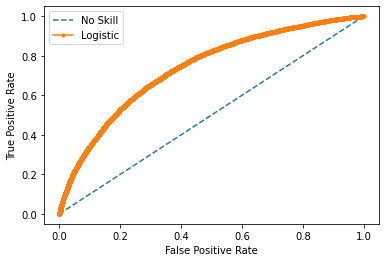

In [16]:
# calculate scores
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
test_thresholds = [ 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

df_results = pd.DataFrame(columns = ['threshold', 'specificity', 'sensitivity', 'accuracy'])
for threshold in test_thresholds:
    mat, spec, sens, acc = confusion_eval(model, X_test, y_test, threshold=threshold)
    
    df_new = pd.DataFrame({'threshold':threshold, 'specificity':spec, 'sensitivity':sens, 'accuracy':acc}, index=[0])
    df_results = pd.concat([df_results,df_new])

In [ ]:
df_results

#### plot threshold results

In [ ]:
def plot_compare(metric):
    for thresh, result in zip(test_thresholds, metric):